In [1]:
# 說明：設置環境、import 套件
import pandas as pd
import numpy as np
import pprint 
import matplotlib.pyplot as plt
from matplotlib import pylab
%pylab inline
plt.style.use('ggplot')
pylab.rcParams['figure.figsize'] = (20, 8)

Populating the interactive namespace from numpy and matplotlib


In [2]:
# color sets
cPurple = '#5628B4'
cLightPurple = '#9590D0'
cRed = '#D2553E'
cGreen = '#98B855'

In [4]:
# Global variables
CostRate = 3 # 一度電多少錢（估算，實際還要再確認）

### 原始資料說明 - 1
- 區間：去年 07/30 - 02/24，七一天
    - 這份資料區間以方便分析為主，所以 71 天只是 1.0 版本，之後會擴張到整學期
- 間隔：一小時一筆
- 地點：所有的學生宿舍，以下我是針對十二舍做
- 一個地點的筆數：每棟大樓共 71(day) * 24(hr) = 1704 筆
- 總筆數 = 1704 * 17 = 28968 筆

In [6]:
df = pd.read_csv('../01data/[new]d12_歷史用電_20170730_20180224.csv') # 讀檔案
df.tail()

,Unnamed: 0,DateTime,Area,Building,Loop,Type,Usage,Date,Weekday,Time,Week,Cost(2.8)
5028,5028,2018/02/24 19:00,S,D12,main,dorm,63.0,2018-02-24,6,19:00,8,176.4
5029,5029,2018/02/24 20:00,S,D12,main,dorm,106.0,2018-02-24,6,20:00,8,296.8
5030,5030,2018/02/24 21:00,S,D12,main,dorm,120.0,2018-02-24,6,21:00,8,336.0
5031,5031,2018/02/24 22:00,S,D12,main,dorm,121.0,2018-02-24,6,22:00,8,338.8
5032,5032,2018/02/24 23:00,S,D12,main,dorm,120.0,2018-02-24,6,23:00,8,336.0


### 原始資料說明 - 2
- index: ['﻿時  間', '區 域', '館 舍 別', '迴 路 別', '用電別', '用電量(單位:度)']

### 人工資料前處理：改變欄位名稱
#### 改變的原因
- 原始的資料有空白在字串裡，會造成一些麻煩
- 英文的名稱，可以在Pandas寫Code時較為方便(才能用 df.Usage的指令)

#### 改了什麼
- 我用Number(Excel)的尋找取代功能，把資料轉成英文，以下括弧表示原始資料的命名
    - 區域：southArea(南區), northArea(北區)
    - 迴 路 別: mainLoop（主迴路）, familyMart（1F便利超商）, club（社團）, socialHall（閱覽交誼廳）, studentHall（學生交誼廳）, streetLight(環校路燈),
    - 館舍： dorm_13（學生十三舍）,(7,8,9,10,11,12 以此類推), dorm_graduate_2（研二）, dorm_87（學生七舍＿八舍）, dorm_13_graduate_1(11與研一), dorm_chu（竹軒）
    - 用電別：rent（外租）, dorm（宿舍）, admin(行政)

Adrain建議: 這部分應該透過 Pandas 寫好，才可以省下每筆資料要手動處理的時間

---
# 以下開始，正式透過 Pandas 來處理 / 分析資料

### 新增欄位：由DateTime的資訊，新增日期、時間、Weekday、Week
- def generate_date_time_columns(df)
    - 放進一個含有 DateTime 欄位的 df, 並寫且回傳新增 Date, Time, Weekday, Week的欄位
- Date, Time: 為了之後更方便用日期、時間去存取，分群比較。
- Weekday: 為了去了解週一到週日的用電變化
- Weekday: 為了後續容易掌握每週變化

In [21]:
# def generate_date_time_columns(df):
#     if('DateTime' in df.columns):
#             df['Date'] = df.DateTime.str[:10]
#             df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
#             df['Weekday'] = df['Date'].dt.dayofweek + 1
#             df['Time'] = df.DateTime.str[11:]
#             df['Week'] = df['Date'].dt.week
#             print('Columns #Date, #Time, #Weekday, #Week has been generated from DateTime and added to DataFrame')
#     else:
#         print('DataTime not in column. Please rename columns name.')
#     return df

In [22]:
# df = generate_date_time_columns(df)

Columns #Date, #Time, #Weekday, #Week has been generated from DateTime and added to DataFrame


In [23]:
# # cost_rate：一度電大概多少錢
# def generate_cost_columns(df, cost_rate):
#     df['Cost'] = df.Usage * cost_rate
#     print('Column "Cost" had been generated!')
#     return df

In [24]:
# df = generate_cost_columns(df, CostRate)

Column "Cost" had been generated!


### 將資料切成三份
原本的資料集包含不同種類（宿舍、外租、行政）的欄位，而因為我們要專注分析宿舍用電，所以將資料切成三份

In [7]:
df_dorm = df[df.Type == 'dorm'] #以下專注在 df_dorm的分析
df_rent = df[df.Type == 'rent']
df_admin = df[df.Type == 'admin']

### 處理 df_dorm 的離群值

In [72]:
# 找離群值：找出最大的五個值，用肉眼可以看出離群值
df_dorm.sort_values('Usage')[-40:]

,Unnamed: 0,DateTime,Area,Building,Loop,Type,Usage,Date,Weekday,Time,Week,Cost(2.8)
1413,1413,2017/09/26 21:00,S,D12,main,dorm,194.0,2017-09-26,2,21:00,39,543.2
1365,1365,2017/09/24 21:00,S,D12,main,dorm,194.0,2017-09-24,7,21:00,38,543.2
1294,1294,2017/09/21 22:00,S,D12,main,dorm,194.0,2017-09-21,4,22:00,38,543.2
1246,1246,2017/09/19 22:00,S,D12,main,dorm,194.5,2017-09-19,2,22:00,38,544.6
934,934,2017/09/06 22:00,S,D12,main,dorm,195.5,2017-09-06,3,22:00,36,547.4
1462,1462,2017/09/28 22:00,S,D12,main,dorm,196.5,2017-09-28,4,22:00,39,550.2
1270,1270,2017/09/20 22:00,S,D12,main,dorm,197.0,2017-09-20,3,22:00,38,551.6
957,957,2017/09/07 21:00,S,D12,main,dorm,198.5,2017-09-07,4,21:00,36,555.8
1247,1247,2017/09/19 23:00,S,D12,main,dorm,198.5,2017-09-19,2,23:00,38,555.8
1774,1774,2017/10/11 22:00,S,D12,main,dorm,199.0,2017-10-11,3,22:00,41,557.2


In [73]:
df_dorm.iloc[2540:2590]

,Unnamed: 0,DateTime,Area,Building,Loop,Type,Usage,Date,Weekday,Time,Week,Cost(2.8)
2540,2540,2017/11/12 21:00,S,D12,main,dorm,7.0,2017-11-12,7,21:00,45,19.6
2541,2541,2017/11/12 22:00,S,D12,main,dorm,207.0,2017-11-12,7,22:00,45,579.6
2542,2542,2017/11/12 23:00,S,D12,main,dorm,105.0,2017-11-12,7,23:00,45,294.0
2543,2543,2017/11/13 00:00,S,D12,main,dorm,89.5,2017-11-13,1,00:00,46,250.6
2544,2544,2017/11/13 01:00,S,D12,main,dorm,69.5,2017-11-13,1,01:00,46,194.6
2545,2545,2017/11/13 02:00,S,D12,main,dorm,65.0,2017-11-13,1,02:00,46,182.0
2546,2546,2017/11/13 03:00,S,D12,main,dorm,61.0,2017-11-13,1,03:00,46,170.8
2547,2547,2017/11/13 04:00,S,D12,main,dorm,56.0,2017-11-13,1,04:00,46,156.8
2548,2548,2017/11/13 05:00,S,D12,main,dorm,51.0,2017-11-13,1,05:00,46,142.8
2549,2549,2017/11/13 06:00,S,D12,main,dorm,44.5,2017-11-13,1,06:00,46,124.6


In [44]:
# 手動改離群值，如果離群值太多得用更完整的方式
df.loc[2578,'Usage']  = 60 #  約是前後的值得大小
df.loc[2578,'Cost(2.8)']  = df.loc[2578,'Usage'] * CostRate # 記得連Cost 一起改過來
df.loc[2582,'Usage']  = 50 #  約是前後的值得大小
df.loc[2582,'Cost(2.8)']  = df.loc[2582,'Usage'] * CostRate # 記得連Cost 一起改過來
df.iloc[2578]
df.iloc[2582]

Unnamed: 0                2582
DateTime      2017/11/14 17:00
Area                         S
Building                   D12
Loop                      main
Type                      dorm
Usage                       50
Date                2017-11-14
Weekday                      2
Time                     17:00
Week                        46
Cost(2.8)                  150
Cost                       150
Name: 2582, dtype: object

In [45]:
df_dorm_12.Cost.max()

180.0

In [14]:
# 這天的離群值，猜測來自之前欄位的位移
# 驗證：看之前欄位的值，有2145筆是零
print(df.iloc[4207:6277].Usage.value_counts())

18.5     38
18.0     34
19.5     33
30.0     33
19.0     29
31.0     28
33.0     26
32.0     24
30.5     23
22.0     21
29.0     17
31.5     16
21.5     16
17.5     15
34.0     13
21.0     13
20.0     13
32.5     12
25.0     11
23.0     11
37.0     10
24.5     10
29.5     10
35.0     10
33.5      9
28.0      9
36.0      9
36.5      8
17.0      8
24.0      7
         ..
69.5      1
74.5      1
88.5      1
64.5      1
67.5      1
85.5      1
79.0      1
87.0      1
54.5      1
76.0      1
86.0      1
75.0      1
61.0      1
52.5      1
71.0      1
64.0      1
16.0      1
15.5      1
85.0      1
117.0     1
48.5      1
93.5      1
126.0     1
114.0     1
123.0     1
125.0     1
128.0     1
112.0     1
119.0     1
129.5     1
Name: Usage, Length: 143, dtype: int64


### 了解每個欄位有多少種不同的值
因為Pandas似乎只有內建針對特定欄位的 unique ，而沒有把所有欄位的Unique 一次列出來的功能，
就自己寫一個

In [15]:
# 用自訂函式去理解DF中每個欄位有哪幾種類別的值
def understand(df):
    for col_name in df.columns:
        print ('>>> "{}" has {} unique values:'.format(col_name, len(df[col_name].unique())))
        if(len(df[col_name].unique())<50):
            pprint.pprint(df[col_name].unique())
        else:
            pprint.pprint('The value is more than 50 so wont be list here :P')
        print('\n')
understand(df_dorm)

>>> "Unnamed: 0" has 5033 unique values:
'The value is more than 50 so wont be list here :P'


>>> "DateTime" has 5033 unique values:
'The value is more than 50 so wont be list here :P'


>>> "Area" has 1 unique values:
array(['S'], dtype=object)


>>> "Building" has 1 unique values:
array(['D12'], dtype=object)


>>> "Loop" has 1 unique values:
array(['main'], dtype=object)


>>> "Type" has 1 unique values:
array(['dorm'], dtype=object)


>>> "Usage" has 371 unique values:
'The value is more than 50 so wont be list here :P'


>>> "Date" has 210 unique values:
'The value is more than 50 so wont be list here :P'


>>> "Weekday" has 7 unique values:
array([7, 1, 2, 3, 4, 5, 6])


>>> "Time" has 24 unique values:
array(['00:00', '01:00', '02:00', '03:00', '04:00', '05:00', '06:00',
       '07:00', '08:00', '09:00', '10:00', '11:00', '12:00', '13:00',
       '14:00', '15:00', '16:00', '17:00', '18:00', '19:00', '20:00',
       '21:00', '22:00', '23:00'], dtype=object)


>>> "Week" has 31 u

# Part 2 Dorm 12 分析
我們先嘗試建立一個對於交大十二舍(Dorm 12)的分析，接著把這樣的分析方式寫成 general function()，套用到其他宿舍上

In [18]:
df_dorm_12 = df[df.Building == 'D12']

### 基本資訊

In [19]:
df_dorm_12.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5033 entries, 0 to 5032
Data columns (total 13 columns):
Unnamed: 0    5033 non-null int64
DateTime      5033 non-null object
Area          5033 non-null object
Building      5033 non-null object
Loop          5033 non-null object
Type          5033 non-null object
Usage         5033 non-null float64
Date          5033 non-null object
Weekday       5033 non-null int64
Time          5033 non-null object
Week          5033 non-null int64
Cost(2.8)     5033 non-null float64
Cost          2 non-null float64
dtypes: float64(3), int64(3), object(7)
memory usage: 550.5+ KB


In [21]:
understand(df_dorm_12)

>>> "Unnamed: 0" has 5033 unique values:
'The value is more than 50 so wont be list here :P'


>>> "DateTime" has 5033 unique values:
'The value is more than 50 so wont be list here :P'


>>> "Area" has 1 unique values:
array(['S'], dtype=object)


>>> "Building" has 1 unique values:
array(['D12'], dtype=object)


>>> "Loop" has 1 unique values:
array(['main'], dtype=object)


>>> "Type" has 1 unique values:
array(['dorm'], dtype=object)


>>> "Usage" has 369 unique values:
'The value is more than 50 so wont be list here :P'


>>> "Date" has 210 unique values:
'The value is more than 50 so wont be list here :P'


>>> "Weekday" has 7 unique values:
array([7, 1, 2, 3, 4, 5, 6])


>>> "Time" has 24 unique values:
array(['00:00', '01:00', '02:00', '03:00', '04:00', '05:00', '06:00',
       '07:00', '08:00', '09:00', '10:00', '11:00', '12:00', '13:00',
       '14:00', '15:00', '16:00', '17:00', '18:00', '19:00', '20:00',
       '21:00', '22:00', '23:00'], dtype=object)


>>> "Week" has 31 u

In [22]:
df_dorm_12.Usage.describe() # 統計上了解用電狀況

count    5033.000000
mean       68.011921
std        40.348073
min         3.000000
25%        33.500000
50%        61.000000
75%        93.500000
max       352.000000
Name: Usage, dtype: float64

# 2.1 十二舍繪圖分析
## 了解變化
- 了解各周的變化：
- 了解星期一在每週的變化
- 了解日用電隨小時的變化：平均
    - 每週平均比較
    - 各週星期一比較
- 成長率
    - 每星期一的變化
    - 每小時變化：抓出突然用電

## 異常值
- 最大值
- 最小值

## 多館舍比較
- 日夜用電比
- Box Plot


In [24]:
# 12舍的總電費（假設一度 3 元）
money = df_dorm_12.groupby('Date').sum().reset_index().Cost.sum()
date = df_dorm_12.Date.unique()
print('If one degree electricity costs {} NTD, from {} to {} ({} day), dorm 12 costs {} NTD'.format(CostRate,str(date[-1])[:10],str(date[0])[:10],len(date),money))

If one degree electricity costs 3 NTD, from 2018-02-24 to 2017-07-30 (210 day), dorm 12 costs 330.0 NTD


### 圖一：每個小時的用電，71天（Line Plot）
#### 觀察
- 週末的時候（藍線最高點），通常用電比較低
- 圖片中間有個低潮，猜測是國慶連假
- 隨著冬天而下降
- 資料波動大

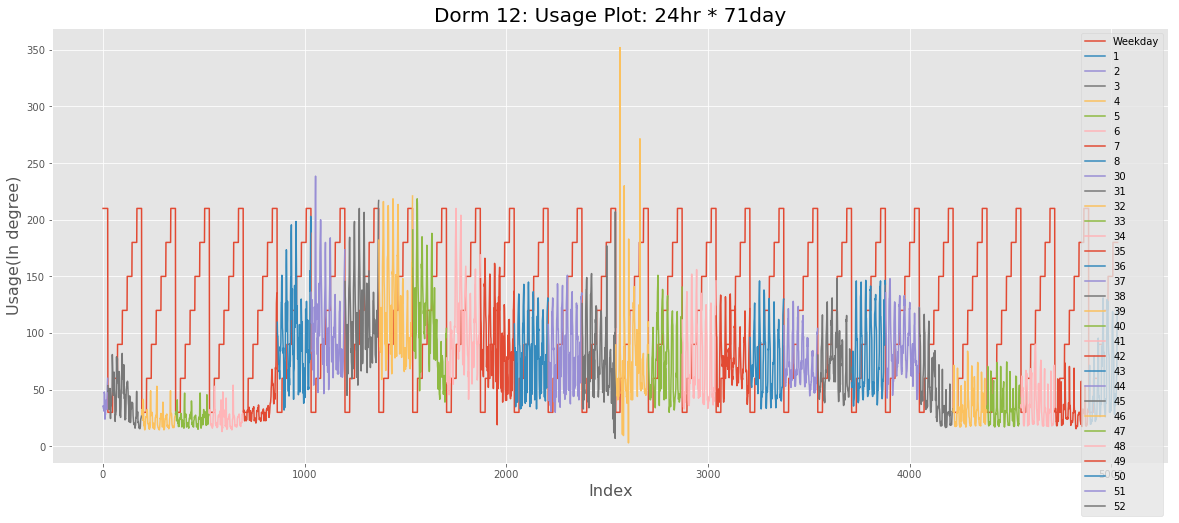

In [25]:
# 71 天每小時的用電資料 (1704個點)

(df_dorm_12.Weekday * 30).plot(legend = True)
# plt.xlabel('index')

df_dorm_12.groupby(['Week']).Usage.plot(legend = True)
#.Usage.plot(legend = True)
plt.title('Dorm 12: Usage Plot: 24hr * 71day', fontsize = 20)
pylab.ylabel('Usage(In degree)',fontsize = 16)
pylab.xlabel('Index',fontsize = 16)


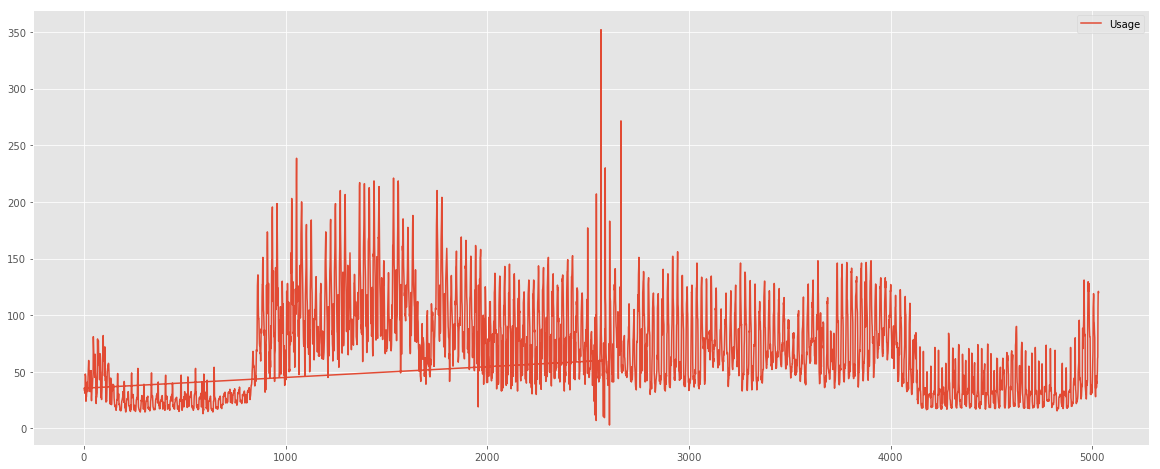

In [48]:
df_dorm_12.sort_values('Cost').Usage.plot(legend = True)

In [49]:
df_dorm_12.Usage.max()

352.0

### 圖二：最高日用電 
討論極端值的成因

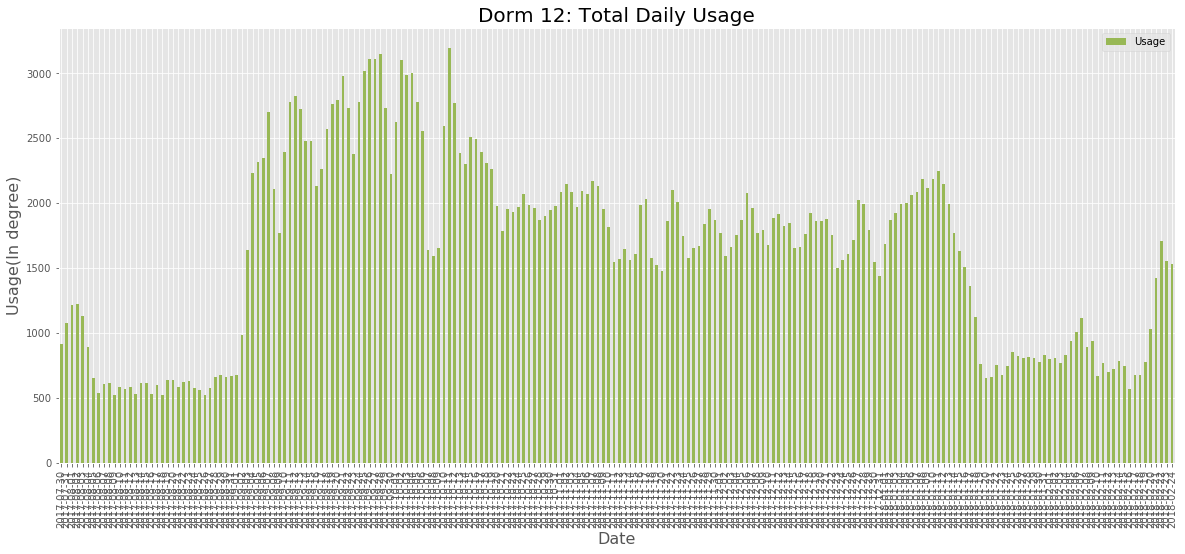

In [50]:
df_dorm_12_dailysum = df_dorm_12.groupby('Date').sum()
df_dorm_12_dailysum.Weekday = df_dorm_12_dailysum.Weekday/24
df_dorm_12_dailysum.Usage.plot.bar(legend = True,color = cGreen)
plt.title('Dorm 12: Total Daily Usage', fontsize = 20)
pylab.ylabel('Usage(In degree)',fontsize = 16)
pylab.xlabel('Date',fontsize = 16)

In [51]:
# 最高用電的幾天是...
# 為什麼這幾天會比較高呢？
print('Top 10 daily TOTAL use of dorm 12. From 9.01 - 11.10')
print(df_dorm_12_dailysum.sort_values('Usage')[-10:])
# print('Top 10 daily AVERAGE use of dorm 12. From 9.01 - 11.10')
# print(df_dorm_12_dailymean_sorted[-10:])

Top 10 daily TOTAL use of dorm 12. From 9.01 - 11.10
            Unnamed: 0   Usage  Weekday  Week  Cost(2.8)  Cost
Date                                                          
2017-09-12       25620  2821.5      2.0   888     7900.2   0.0
2017-09-21       30804  2973.5      4.0   912     8325.8   0.0
2017-10-03       37716  2981.0      2.0   960     8346.8   0.0
2017-10-04       38292  3003.0      3.0   960     8408.4   0.0
2017-09-25       33108  3019.0      1.0   936     8453.2   0.0
2017-10-02       37140  3100.0      1.0   960     8680.0   0.0
2017-09-27       34260  3105.0      3.0   936     8694.0   0.0
2017-09-26       33684  3108.0      2.0   936     8702.4   0.0
2017-09-28       34836  3150.0      4.0   936     8820.0   0.0
2017-10-11       42324  3189.5      3.0   984     8930.6   0.0


觀察：其實最高用電的前十個日子，大多發生在九月十月，而且有連續的現象！

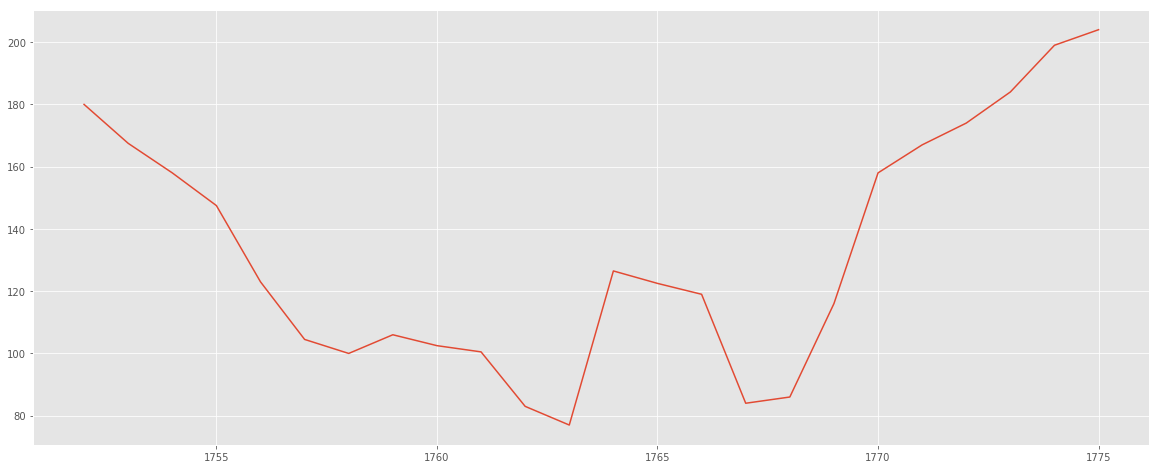

In [52]:
# 10.11 的用電繪圖
df_dorm_12[df_dorm_12.Date == '2017-10-11'].Usage.plot()
# xticks = list(df_dorm_12.Time.unique()) # bug to fix!!
# 不正常的地方：中午高峰

In [53]:
# 哪小時最耗電？
df_dorm_12.sort_values('Usage')[-100:].Time.value_counts()

22:00    26
23:00    24
21:00    19
00:00    13
20:00     9
19:00     4
01:00     3
03:00     1
06:00     1
Name: Time, dtype: int64

,Unnamed: 0,DateTime,Area,Building,Loop,Type,Usage,Date,Weekday,Time,Week,Cost(2.8),Cost
2564,2564,2017/11/13 23:00,S,D12,main,dorm,352.0,2017-11-13,1,23:00,46,985.6,NaN


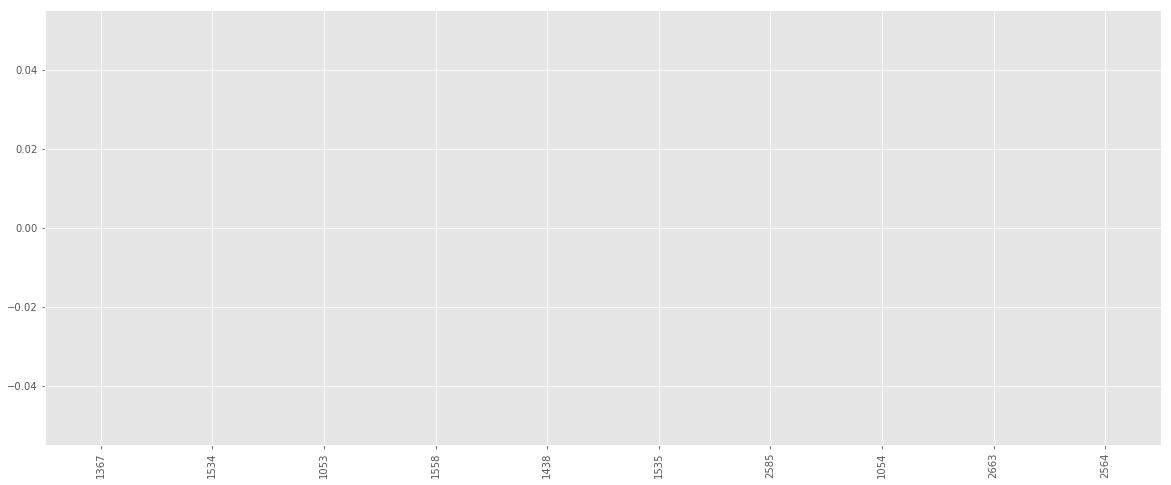

In [54]:
# Top 10 用電
# 看一下特高用電有多誇張，結果其實還好
df_dorm_12.sort_values('Usage')[-10:].Cost.plot.bar(color = cRed)
#發現有一小時真的特耗電

df_dorm_12.sort_values('Usage')[-1:]
# 2017/09/11 22:00 用電是 238.5, (12舍平均用電是96)

2017/9/11 為什麼用那麼多電呢？
我去查了日曆，原來是開學日的十點（一起打電動？煮火鍋？）

In [55]:
# 五十天中，星期幾最耗電？
df_dorm_12.groupby('Date').mean().sort_values('Usage')[-50:].Weekday.value_counts()

4.0    9
3.0    9
2.0    9
1.0    7
5.0    7
7.0    5
6.0    4
Name: Weekday, dtype: int64

### 圖三：平均用電變化 - 依Weekday看
#### 觀察
- 週六大家回家，平均用電最低
- 週日回宿舍，用電比週六週五高

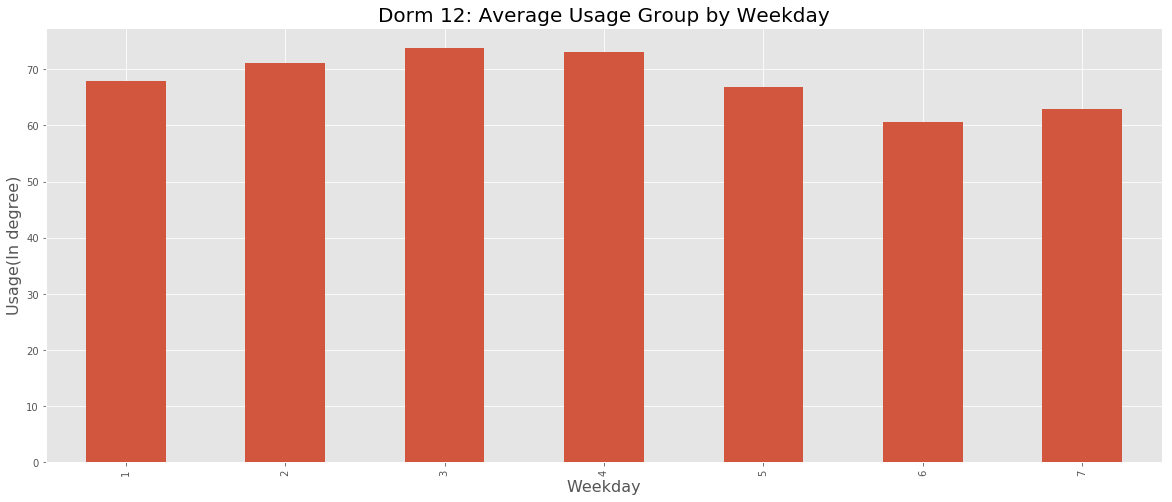

In [56]:
df_dorm_12_byWeekday = df_dorm_12.groupby('Weekday').mean()
df_dorm_12_byWeekday.Usage.plot.bar(legend = False,color = cRed)

plt.title('Dorm 12: Average Usage Group by Weekday', fontsize = 20)
pylab.ylabel('Usage(In degree)',fontsize = 16)
pylab.xlabel('Weekday',fontsize = 16)

### 圖三：各週用電變化 - 依Weekday看

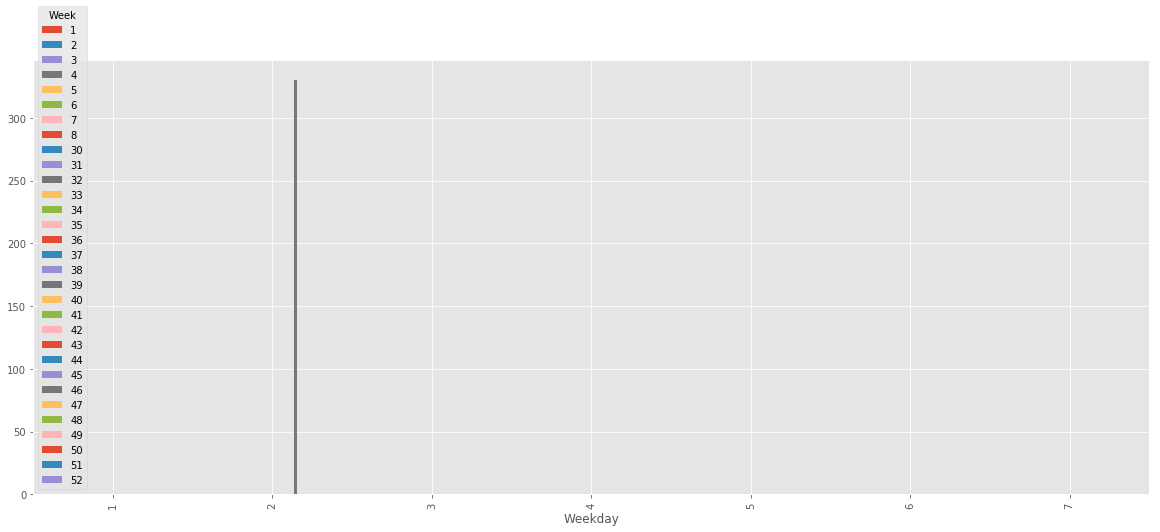

In [57]:
df_dorm_12.groupby(['Weekday','Week']).Cost.sum().unstack().plot.bar(legend = True)
#.Usage.plot(legend = True)
# 跟上一張圖的差別：可以看各周的變化

In [58]:
# 注意：取資料時，週五多一天
df_dorm_12.Weekday.value_counts()

7    720
3    720
5    720
4    720
2    719
1    718
6    716
Name: Weekday, dtype: int64

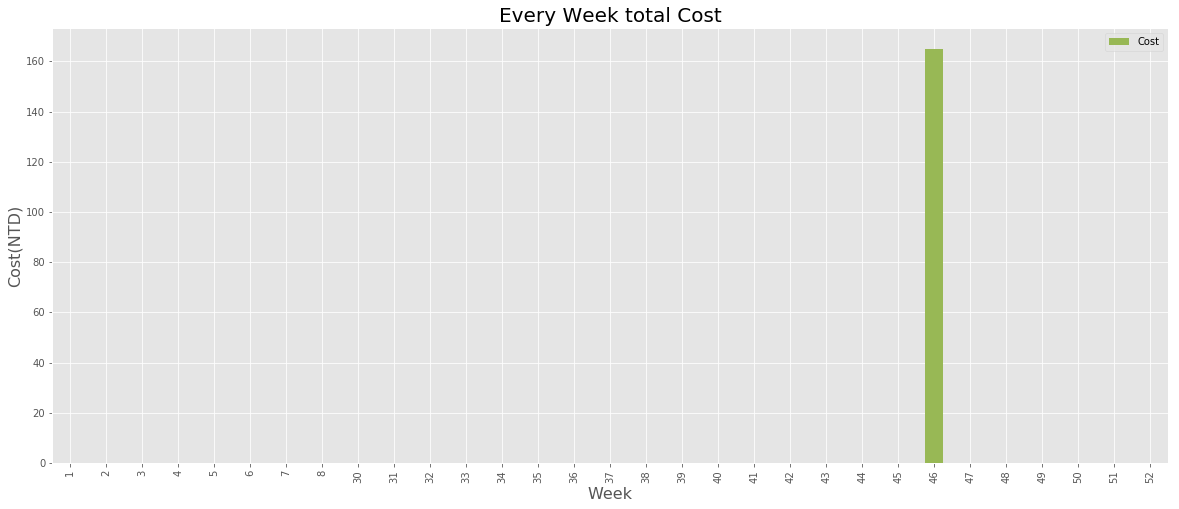

In [60]:
# df_dorm_12.groupby('Date').sum().Usage.plot.bar()
df_dorm_12.groupby('Week').mean().Cost.plot.bar(legend = True, color = cGreen)
plt.title('Every Week total Cost', fontsize = 20)
pylab.ylabel('Cost(NTD)',fontsize = 16)
pylab.xlabel('Week',fontsize = 16)

### 圖四：平均用電變化 - 依小時看

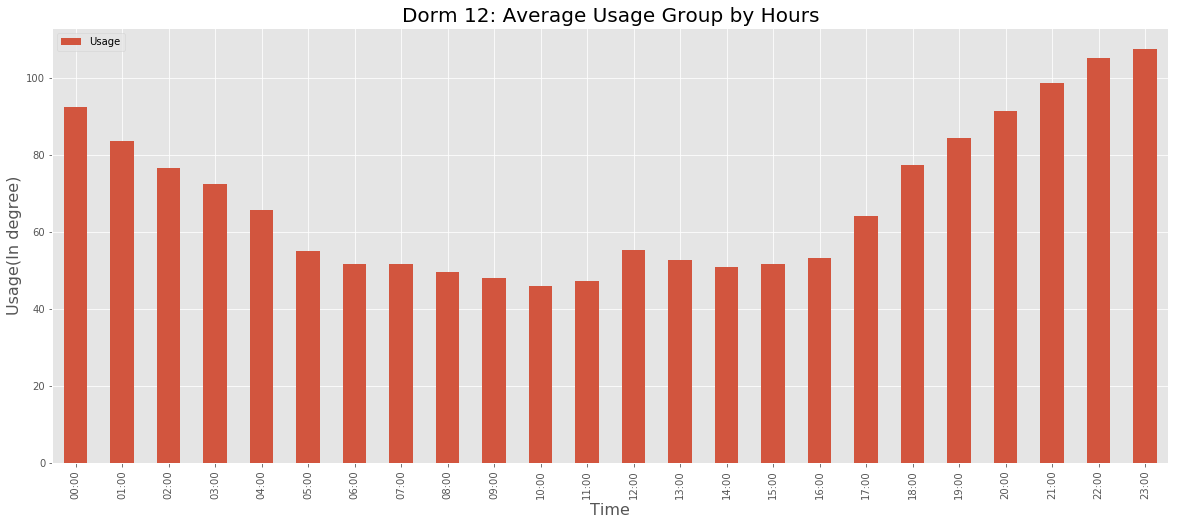

In [61]:
df_dorm_12.groupby('Time').Usage.mean().plot.bar(legend = True, color = cRed)
plt.title('Dorm 12: Average Usage Group by Hours', fontsize = 20)
pylab.ylabel('Usage(In degree)',fontsize = 16)
pylab.xlabel('Time',fontsize = 16)

### 觀察
- 這張是我覺得最有趣的，想法：可以拿去跟男生十舍比，看十二舍的人是不是比較早睡（省電）
- 最高用電落在晚上十一點到十二點。十二點會關燈。
- 關燈之後的下跌應該就是人為用電的減少（去睡覺了），人為用電除了桌電、吹風機以外，不知道洗澡熱水器有沒有被算在內？
- 早上七點起床有個Peak，可能是洗澡或開燈
- 中午十二點也有Peak，可能是回宿舍吃中飯
- 晚上六點開燈，所以用電升幅大

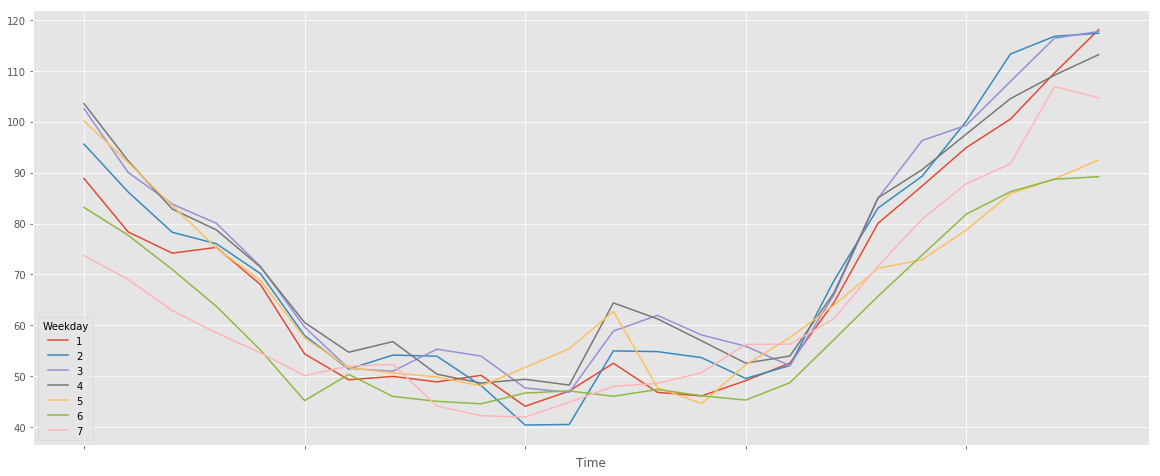

In [62]:
df_dorm_12.groupby(['Time','Weekday']).Usage.mean().unstack().plot(legend = True)
#.Usage.plot(legend = True)

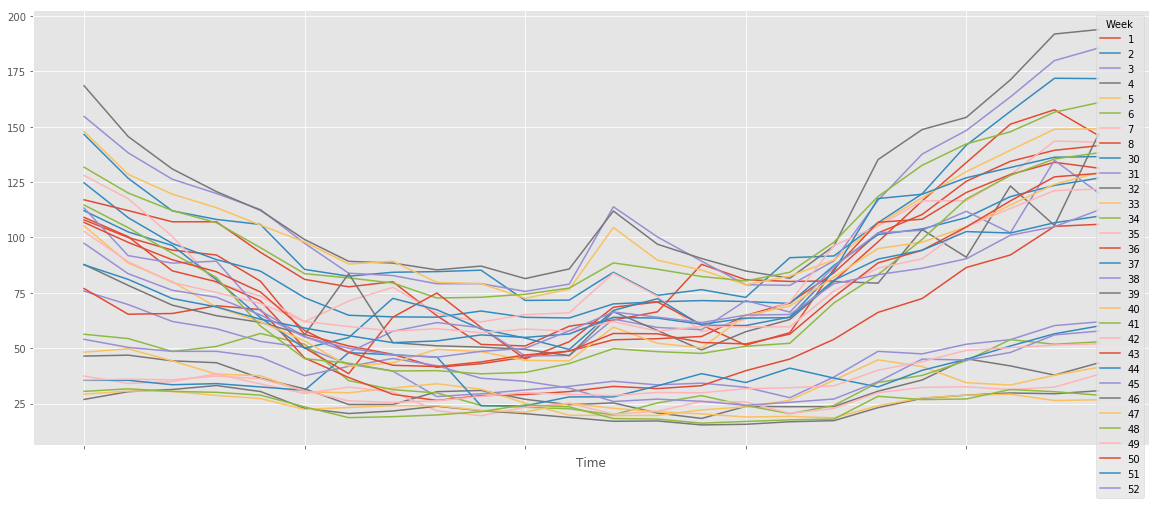

In [63]:
df_dorm_12.groupby(['Time','Week']).Usage.mean().unstack().plot(legend = True)
#.Usage.plot(legend = True)

### 圖七：每周在某一個時刻的用電變化 

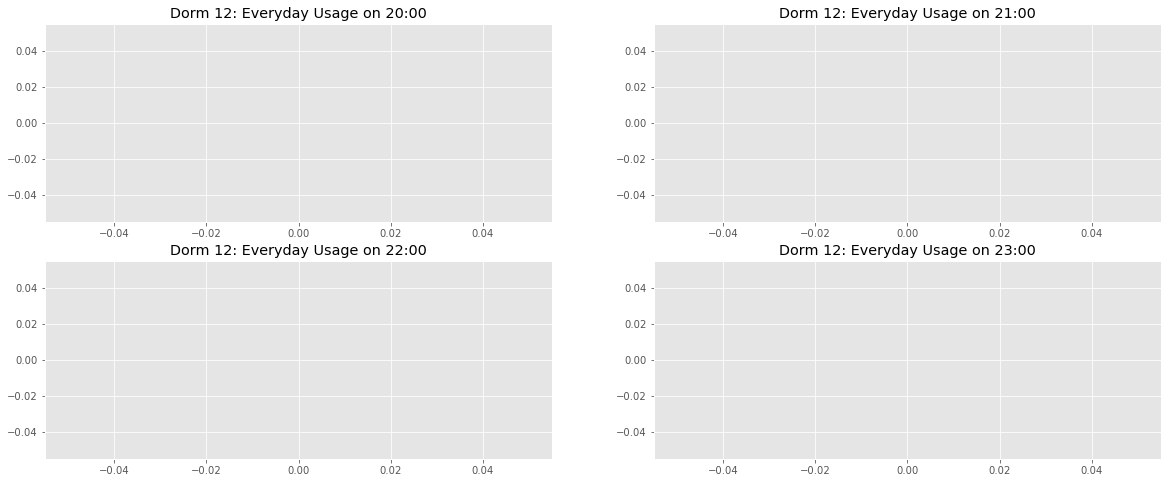

In [64]:
# 觀看某一個小時的用電量，在每天的變化

# df_dorm_12[df_dorm_12.Time == '23:00'].info()
fig, axes = plt.subplots(nrows=2, ncols=2)
df_dorm_12[df_dorm_12.Time == '20:00'].Cost.plot(ax=axes[0,0],title = 'Dorm 12: Everyday Usage on 20:00')
df_dorm_12[df_dorm_12.Time == '21:00'].Cost.plot(ax=axes[0,1],title = 'Dorm 12: Everyday Usage on 21:00')
df_dorm_12[df_dorm_12.Time == '22:00'].Cost.plot(ax=axes[1,0],title = 'Dorm 12: Everyday Usage on 22:00')
df_dorm_12[df_dorm_12.Time == '23:00'].Cost.plot(ax=axes[1,1],title = 'Dorm 12: Everyday Usage on 23:00')

## 成長率

In [65]:
# 使用 .pct_change()
df_dorm_12.groupby(['Week','Weekday']).mean().Cost.pct_change()[-20:]

Week  Weekday
50    2         NaN
      3         NaN
      4         NaN
      5         NaN
      6         NaN
      7         NaN
51    1         NaN
      2         NaN
      3         NaN
      4         NaN
      5         NaN
      6         NaN
      7         NaN
52    1         NaN
      2         NaN
      3         NaN
      4         NaN
      5         NaN
      6         NaN
      7         NaN
Name: Cost, dtype: float64

/Users/ah-bau/anaconda/lib/python3.5/site-packages/matplotlib/transforms.py:661: RuntimeWarning: invalid value encountered in absolute
  inside = ((abs(dx0 + dx1) + abs(dy0 + dy1)) == 0)


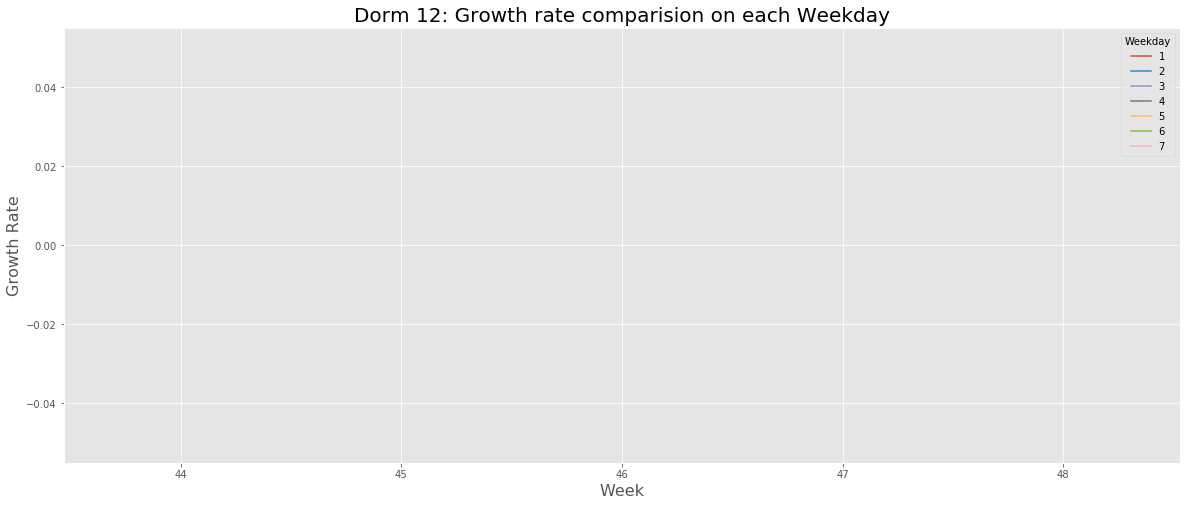

In [66]:
df_dorm_12.groupby(['Week','Weekday']).mean().Cost.pct_change(-1).unstack().plot()
plt.title('Dorm 12: Growth rate comparision on each Weekday', fontsize = 20)
pylab.ylabel('Growth Rate',fontsize = 16)
pylab.xlabel('Week',fontsize = 16) 

In [67]:
#探討peak的成因
df_dorm_12.groupby(['Week','Weekday']).mean().Cost.pct_change(-1).sort_values()[-10:]


Week  Weekday
51    5         NaN
      6         NaN
      7         NaN
52    1         NaN
      2         NaN
      3         NaN
      4         NaN
      5         NaN
      6         NaN
      7         NaN
Name: Cost, dtype: float64

                Unnamed: 0       Usage       Week   Cost(2.8)  Cost
Time  Weekday                                                      
00:00 1        2456.700000   88.833333  31.633333  248.733333   NaN
      2        2480.633333   95.583333  31.633333  267.633333   NaN
      3        2504.600000  102.533333  31.633333  287.093333   NaN
      4        2528.600000  103.533333  31.633333  289.893333   NaN
      5        2552.600000  100.116667  31.633333  280.326667   NaN
      6        2576.600000   83.166667  31.633333  232.866667   NaN
      7        2432.700000   73.683333  32.366667  206.313333   NaN
01:00 1        2457.700000   78.350000  31.633333  219.380000   NaN
      2        2481.633333   86.200000  31.633333  241.360000   NaN
      3        2505.600000   90.033333  31.633333  252.093333   NaN
               Unnamed: 0     Usage      Week  Cost(2.8)  Cost
Time  Weekday                                                 
00:00 1         -0.009648 -0.070619  0.000000  -0.070619  

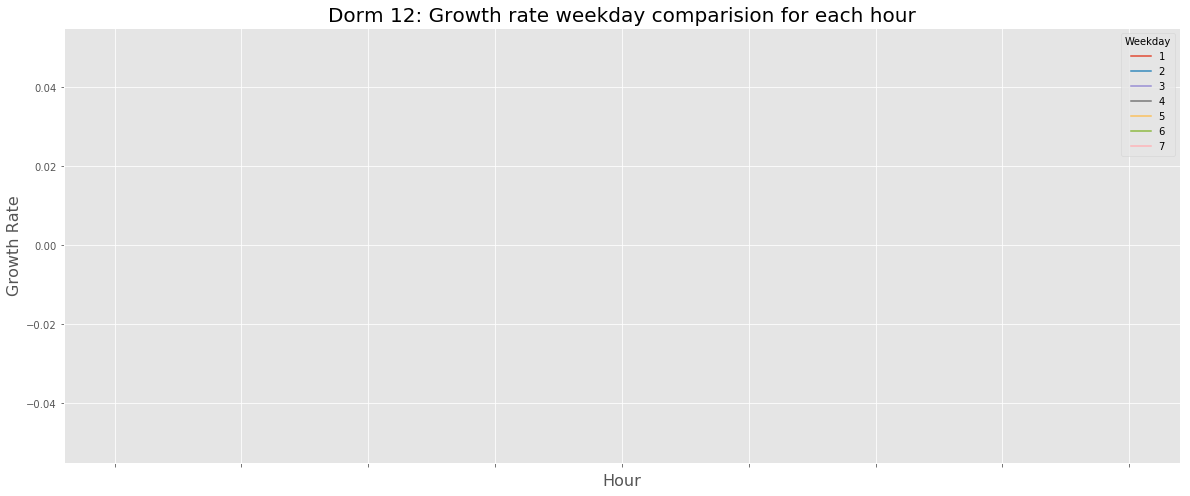

In [68]:
print(df_dorm_12.groupby(['Time','Weekday']).mean()[:10])
print(df_dorm_12.groupby(['Time','Weekday']).mean().pct_change(-1)[:10])
df_dorm_12.groupby(['Time','Weekday']).mean().Cost.pct_change(-1).unstack().plot()
plt.title('Dorm 12: Growth rate weekday comparision for each hour', fontsize = 20)
pylab.ylabel('Growth Rate',fontsize = 16)
pylab.xlabel('Hour',fontsize = 16) 

## 白天 / 晚上用電比率

In [69]:
# df_dorm_12.groupby(['Time','Weekday])
# df_dorm_12_night = df_dorm_12[((df_dorm_12.Time == '03:00') or (df_dorm_12.Time == '04:00') or (df_dorm_12.Time == '05:00'))]
df_dorm_12_night = df_dorm_12.loc[df_dorm_12['Time'].isin(['03:00', '04:00', '05:00', '06:00'])]
df_dorm_12_day = df_dorm_12.loc[df_dorm_12['Time'].isin(['07:00', '08:00', '09:00', '10:00', '11:00', '12:00', '13:00',
       '14:00', '15:00', '16:00', '17:00', '18:00'])]
df_dorm_12_night = df_dorm_12_night.groupby('Date').mean()# 夜晚用電
df_dorm_12_day = df_dorm_12_day.groupby('Date').mean()
(df_dorm_12_day/df_dorm_12_night).head()

,Unnamed: 0,Usage,Weekday,Week,Cost(2.8),Cost
Date,,,,,,
2017-07-30,2.777778,0.946163,1.0,1.0,0.946163,NaN
2017-07-31,1.280702,0.930140,1.0,1.0,0.930140,NaN
2017-08-01,1.152381,0.695988,1.0,1.0,0.695988,NaN
2017-08-02,1.104575,0.746106,1.0,1.0,0.746106,NaN
2017-08-03,1.079602,0.706790,1.0,1.0,0.706790,NaN


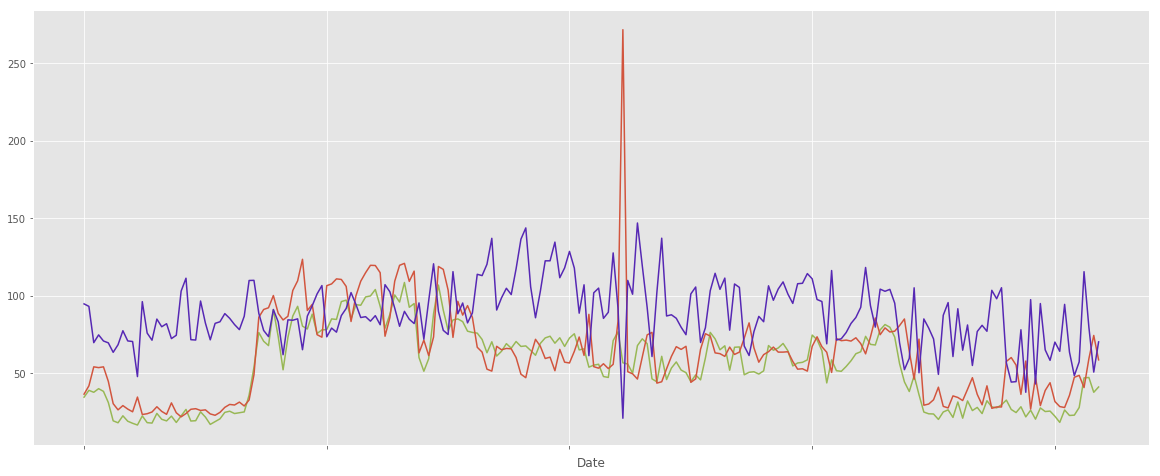

In [70]:
df_dorm_12_day.Usage.plot(color = cGreen)
df_dorm_12_night.Usage.plot(color = cRed)
((df_dorm_12_day/df_dorm_12_night).Usage*100).plot(color = cPurple) 
# bug ： 如何把兩個不同scale的圖畫再一起
# bug ： 如何畫線